/home/atomwalk12/anaconda3/envs/dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:lib.trainers.base_trainer:LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=None, inference_mode=False, r=8, target_modules='all-linear', lora_alpha=16, lora_dropout=0.1, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights='gaussian', layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))
INFO:lib.trainers.base_trainer:BitsAndBytesConfig {
  "bnb_4bit_compute_dtype": "float32",
  "bnb_4bit_quant_type": "nf4",
 

[INFO] Using GPU: NVIDIA GeForce RTX 4090



Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]
INFO:lib.models.blip2_classifier:config.interm_dim=1024
/home/atomwalk12/Dropbox (Old)/notes/vision/project/BeyondVisionQA/VisualQA/lib/models/base_classifier.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full co

trainable params: 0 || all params: 3,765,957,376 || trainable%: 0.0000


/home/atomwalk12/anaconda3/envs/dev/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


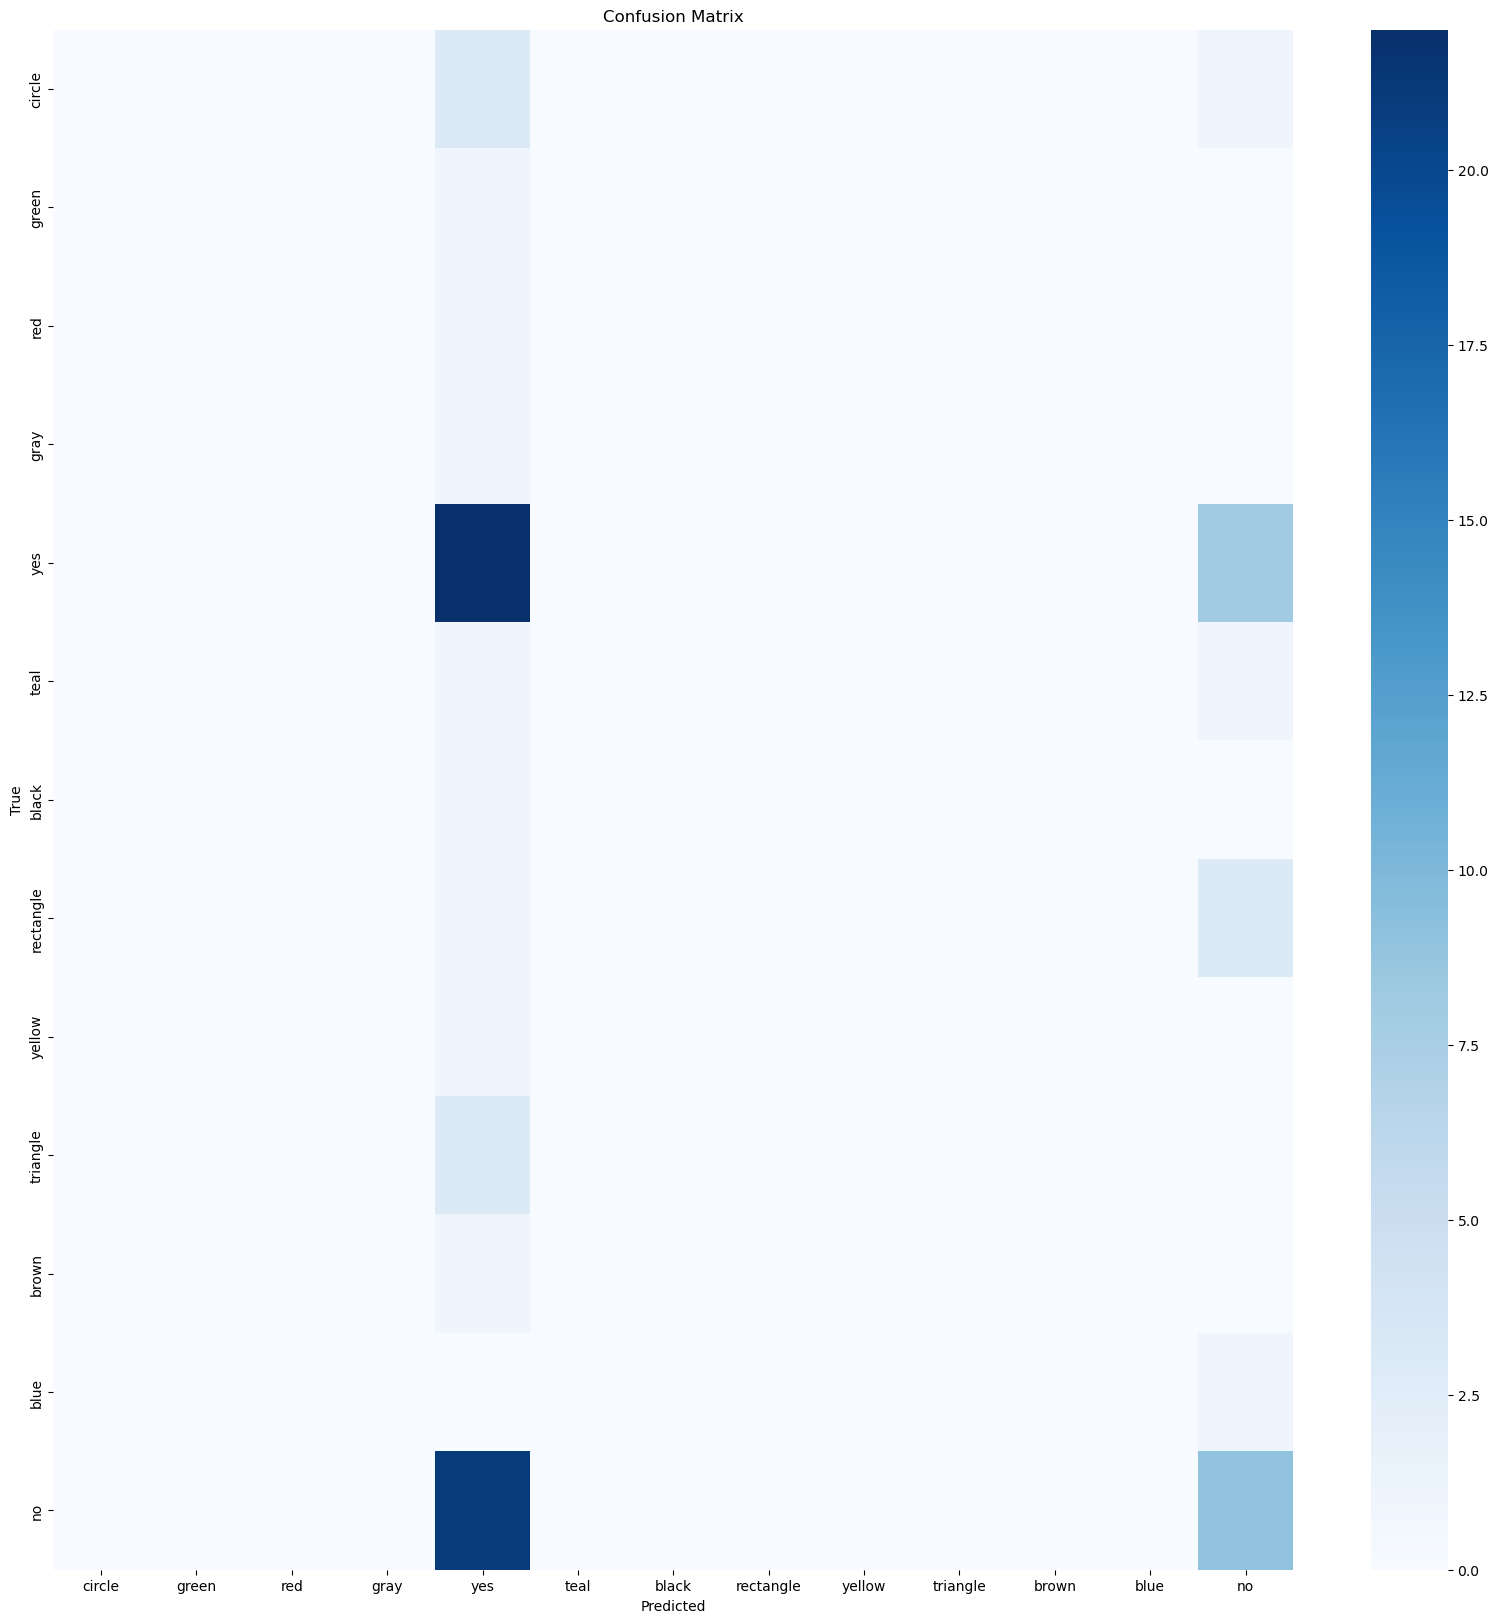

In [1]:
from lib.visualization import show_confusion_matrix


show_confusion_matrix("train[:80]", "easy-vqa")

/home/atomwalk12/anaconda3/envs/dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:lib.trainers.base_trainer:LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=None, inference_mode=False, r=8, target_modules='all-linear', lora_alpha=16, lora_dropout=0.1, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights='gaussian', layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))
INFO:lib.trainers.base_trainer:BitsAndBytesConfig {
  "bnb_4bit_compute_dtype": "float32",
  "bnb_4bit_quant_type": "nf4",
 

[INFO] Using GPU: NVIDIA GeForce RTX 4090



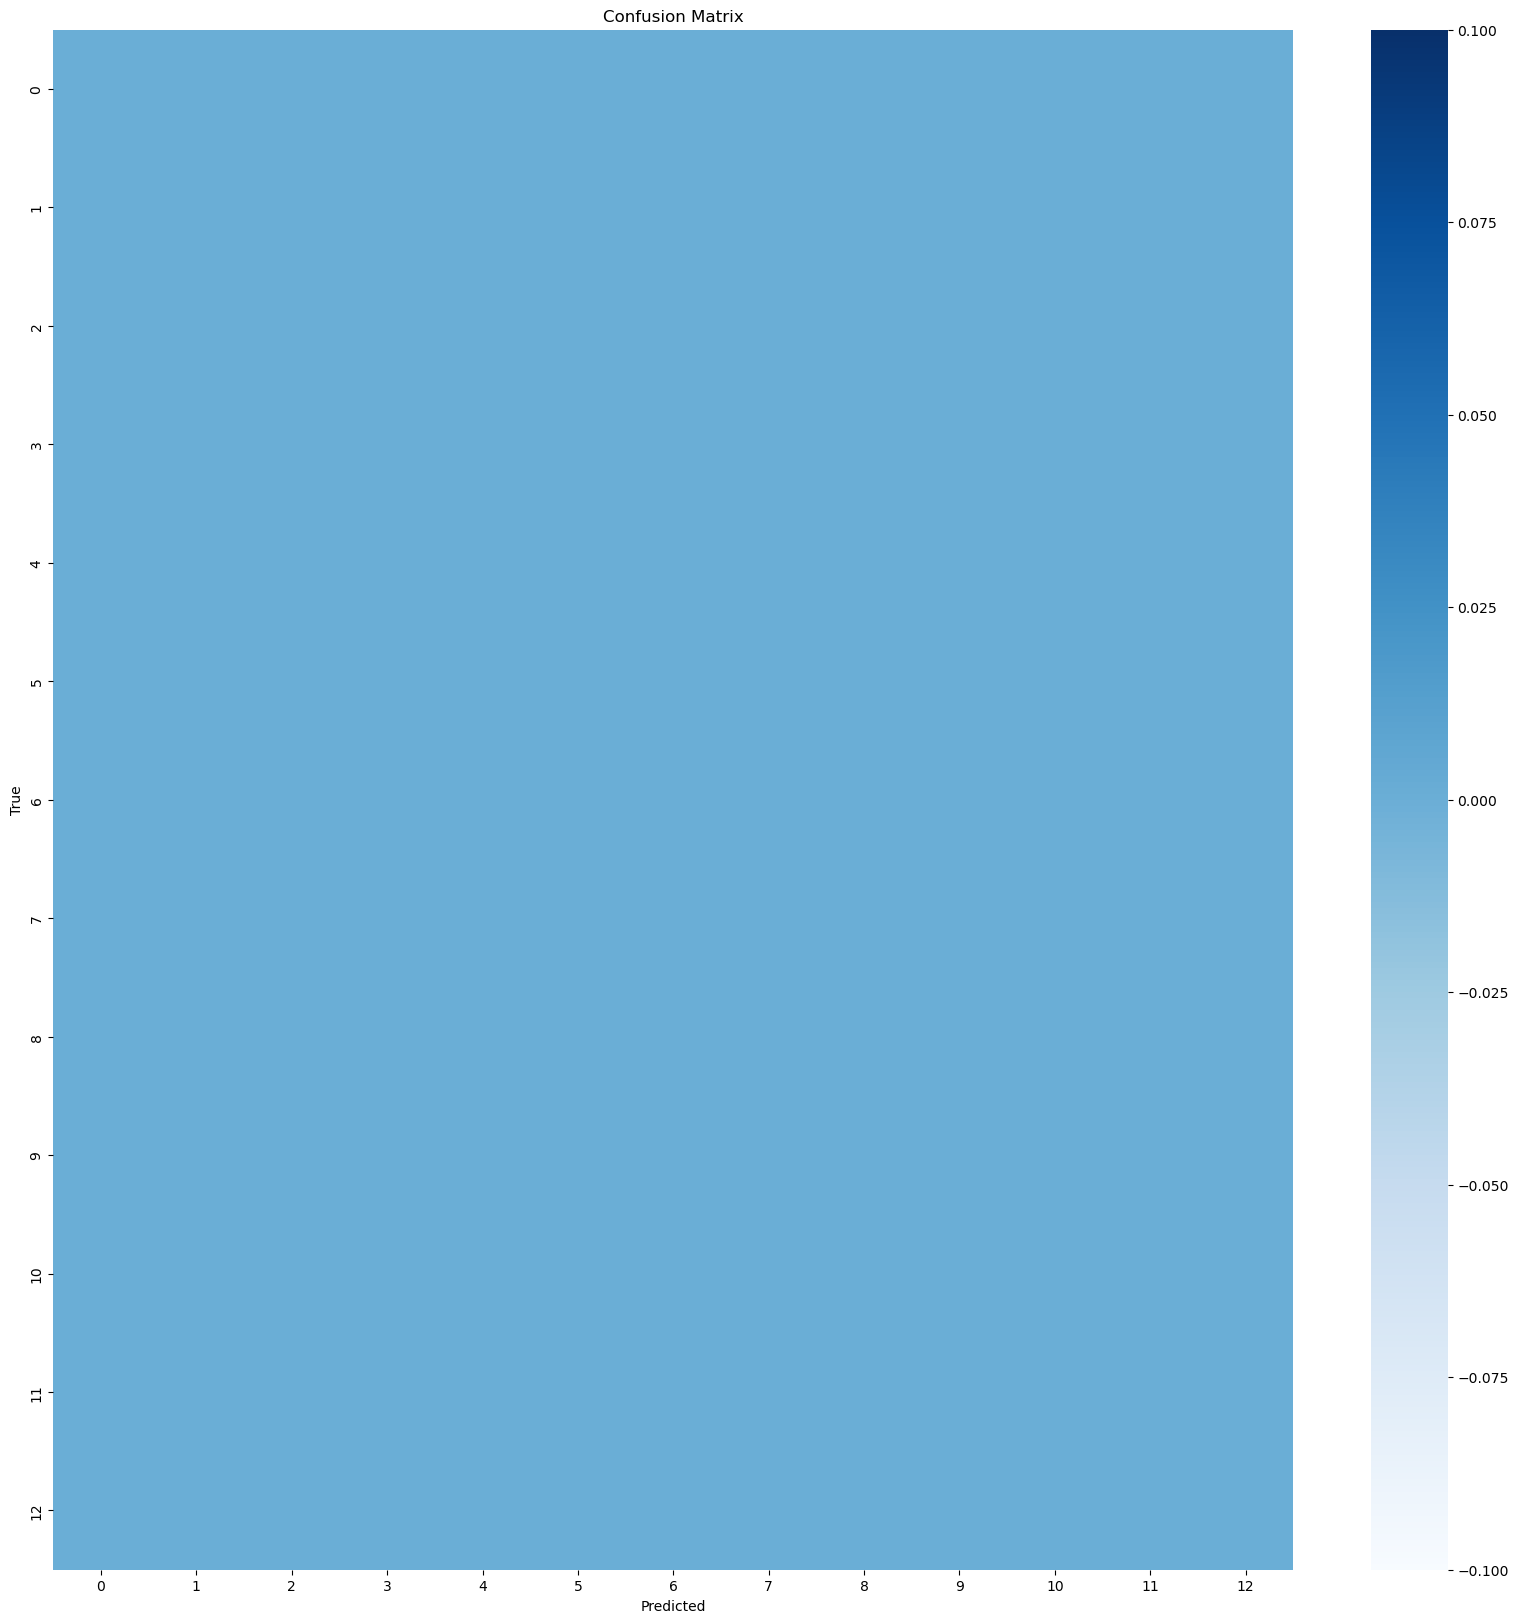

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Visualizer(GenerationTrainer):
    def __init__(self, config: TrainingParameters):
        super().__init__(config)
        self.save_embeddings = True

    def create_embeddings(self):
        """
        Create embeddings to visualize and measure similarities between images.
        The Image Transformer outputs' embedding dimension size is (batch_size, num_query_tokens=32, embedding_dim=768)
        So, we need to reduce the dimension by taking a mean. In this function, it gets dataloader as an input and 
        return a reduced embedding.
        """

        image_name_list = []
        reduced_embeddings = []

        for idx, batch in tqdm(enumerate(self.test_dataloader)):
            images = batch['image']
            image_paths = batch['image_name']

            images = images.to(device)
            samples = {'image': images}

            # features_image: (batch_size, num_query_token, embed_dim)
            features_image = self.model.extract_features(samples, mode='image')
            
            # reduced_embedding: (batch_size, embed_dim)
            reduced_embedding = torch.mean(features_image.image_embeds, dim=1).squeeze(1)
            reduced_embeddings.append(reduced_embedding)
            image_name_list.append(image_paths)

        # concat reduced_embeddings that has a dimension size (all_data_length, embed_dim)
        reduced_embeddings = torch.cat(reduced_embeddings, dim=0)
        reduced_embeddings = reduced_embeddings.detach().cpu().numpy()

        image_name_list = np.array(image_name_list)
        image_name_list = image_name_list.reshape(-1)

        return reduced_embeddings, image_name_list

In [4]:
test_args = VQAParameters(split="train[:1000]", use_stratified_split=True)

parameters = TrainingParameters(
    resume_checkpoint=True,
    model_name=ModelTypes.BLIP2Generator,
    is_trainable=False,
    train_args=None,
    val_args=None,
    test_args=test_args,
)

visualizer = Visualizer(parameters)
visualizer.finetune()

INFO:lib.trainers.base_trainer:LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=None, inference_mode=False, r=16, target_modules='all-linear', lora_alpha=16, lora_dropout=0.1, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights='gaussian', layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))
INFO:lib.trainers.base_trainer:BitsAndBytesConfig {
  "bnb_4bit_compute_dtype": "float32",
  "bnb_4bit_quant_type": "fp4",
  "bnb_4bit_use_double_quant": false,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": false,
  "load_in_8bit": true,
  "quant_method": "bitsandbytes"
}

/ho

[INFO] Using GPU: NVIDIA GeForce RTX 4090



Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]
INFO:lib.datasets_qa.easyvqa_base:Loaded 1000 items from /home/atomwalk12/Dropbox (Old)/notes/vision/project/BeyondVisionQA/VisualQA/data/easy_vqa/generation/train[:1000].pkl
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: paraphrase-MiniLM-L6-v2


trainable params: 0 || all params: 3,787,234,816 || trainable%: 0.0000


/home/atomwalk12/anaconda3/envs/dev/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
wandb: Currently logged in as: razfv07 (razfv07-university-of-bologna). Use `wandb login --relogin` to force relogin


INFO:lib.trainers.base_trainer:Training complete in 0h 0m 0s
INFO:lib.trainers.base_trainer:Best Loss: 0.6818
/home/atomwalk12/anaconda3/envs/dev/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


trainable params: 42,554,880 || all params: 3,787,234,816 || trainable%: 1.1236


/home/atomwalk12/anaconda3/envs/dev/lib/python3.12/site-packages/peft/utils/save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
adapter_model.safetensors:   2%|▏         | 16.3M/685M [00:06<08:00, 1.39MB/s]

KeyboardInterrupt: 

adapter_model.safetensors:   3%|▎         | 19.6M/685M [00:20<07:58, 1.39MB/s]

In [10]:
visualizer.state.history

defaultdict(list,
            {'Train Loss': [3.350183031082153,
              0.4743822231292725,
              0.2578550103902817,
              0.23151999962329864],
             'Valid Loss': [1.1180107278823852,
              0.6818334069252014,
              0.7299867715835572,
              0.7565060667991638]})

: 

In [9]:



user_query = "Who is Spinoza?"

visualize_query_distrib("", 'PCA')

/home/atomwalk12/anaconda3/envs/questllama/lib/python3.9/site-packages/pacmap/pacmap.py:828: UserWarning:




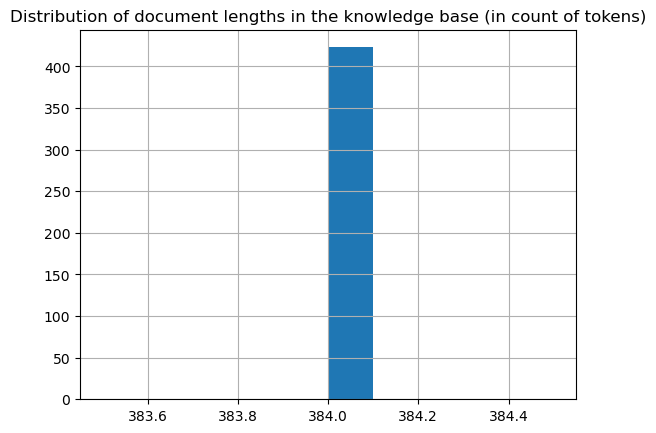

423

In [8]:
import matplotlib.pyplot as plt

lengths = [
    len(embedding_model.get_text_embedding(doc.text)) for doc in chunked_docs
]

fig = pd.Series(lengths).hist()
plt.title(
    "Distribution of document lengths in the knowledge base (in count of tokens)"
)
plt.show()
len(lengths)

In [12]:
indexes = []
for book in books:
    name = Path(book["name"]).stem
    # rebuild storage context
    storage_context = StorageContext.from_defaults(
        persist_dir=f"{HOME}/librarian/index/{book['author']}/{name}"
    )

    # load index
    index = load_index_from_storage(
        storage_context=storage_context,
        service_context=service_context,
        embedding_model="local",
    )

    print(book)
    # Prepare the index for the citation engine
    indexes.append(index)

book_index = indexes[1]

{'author': 'Oscar Wilde', 'name': 'Dorian Gray.pdf'}
{'author': 'Antoine de Saint Exupery', 'name': 'Little Prince.pdf'}
{'author': 'Baruch Spinoza', 'name': 'Ethics.pdf'}


465
{'author': 'Oscar Wilde', 'name': 'Dorian Gray.pdf'}


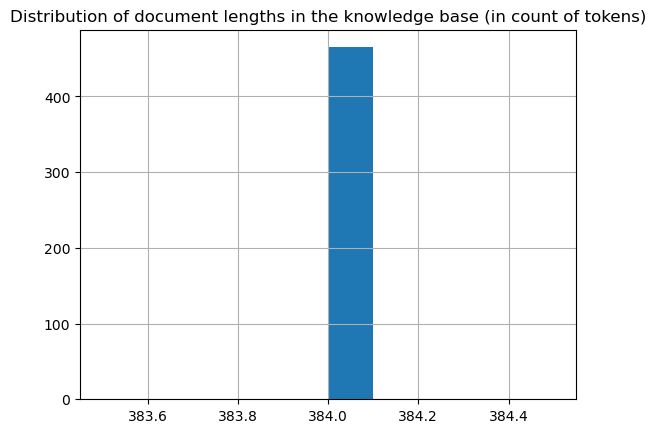

In [10]:
import matplotlib.pyplot as plt

idx=0
print(len(indexes[idx]._vector_store._data.embedding_dict.items()))
print(books[idx])
book_index = indexes[idx]

lengths = [
    len(value) for key, value in book_index._vector_store._data.embedding_dict.items()
]

fig = pd.Series(lengths).hist()
plt.title(
    "Distribution of document lengths in the knowledge base (in count of tokens)"
)
plt.show()


465


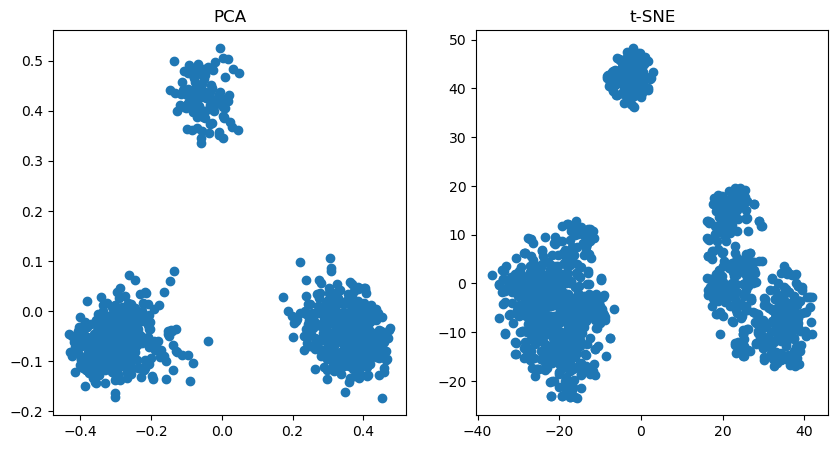

986


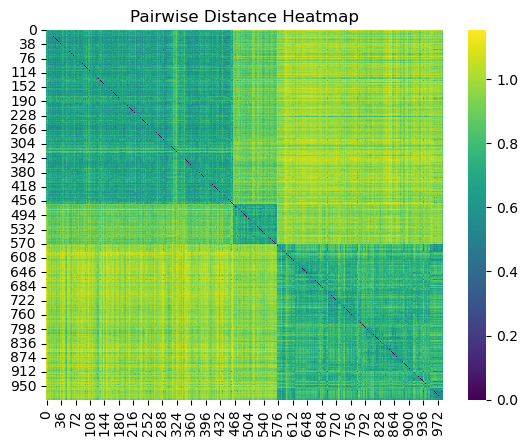

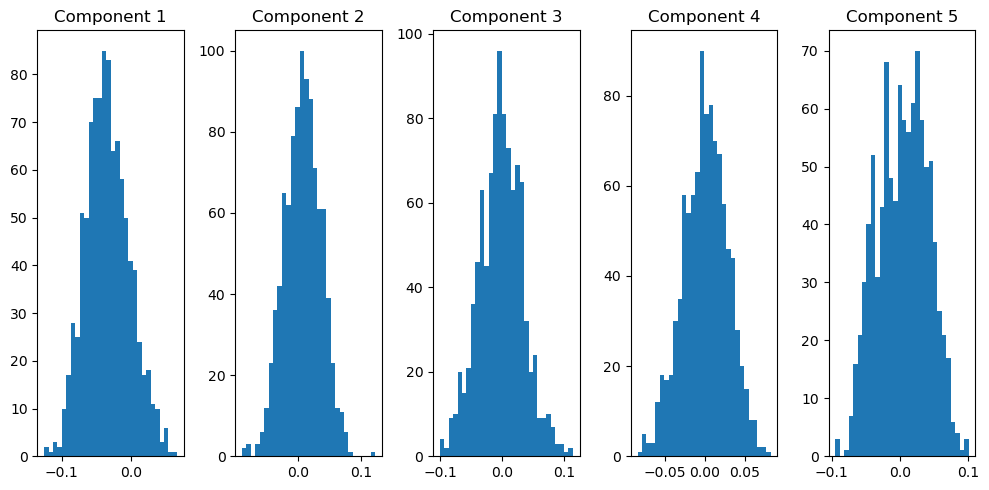

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns


# Generate synthetic data (replace with your embeddings)
data_values1 = list(indexes[0]._vector_store._data.embedding_dict.values())
data_values2 = list(indexes[1]._vector_store._data.embedding_dict.values())
data_values3 = list(indexes[2]._vector_store._data.embedding_dict.values())

# Convert the list of values to a NumPy array
embeddings = np.array(data_values1 + data_values2 + data_values3)

print(len(data_values1))

# Dimensionality Reduction with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# Dimensionality Reduction with t-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(embeddings)

# Plotting PCA results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA')

# Plotting t-SNE results
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE')

plt.show()

# Heatmap of pairwise distances


distances = np.linalg.norm(embeddings[:, np.newaxis] - embeddings, axis=2)

print(len(distances))
# df = pd.DataFrame(
#     distances
# )
# # Initialize the column labels
# column_labels = ['The Picture of Dorian Gray'] * 986  # Default all to "Book3"
# column_labels[:400] = ['The Little Prince'] * 400  # Label 0 to 400 as "Book1"
# column_labels[400:600] = ['Ethics'] * 200  # Label 400 to 600 as "Book2"

# # Assign the labels to the columns
# df.columns = column_labels

sns.heatmap(distances, cmap='viridis') # xticklabels=300, yticklabels=300)
plt.title('Pairwise Distance Heatmap')
plt.savefig("test.png")
plt.show()
# fig = sns_plot.get_figure()
# fig.savefig("img4_seaborn.pdf")


# Component-wise Histogram
plt.figure(figsize=(10, 5))
for i in range(5):  # Plot histograms for the first 5 components
    plt.subplot(1, 5, i + 1)
    plt.hist(embeddings[:, i], bins=30)
    plt.title(f'Component {i+1}')
plt.tight_layout()
plt.show()

In [18]:
df

,Book1,Book1,Book1,Book1,Book1,Book1,Book1,Book1,Book1,Book1,...,Book3,Book3,Book3,Book3,Book3,Book3,Book3,Book3,Book3,Book3
0,0.000000,0.695236,0.743554,0.754812,0.727154,0.702221,0.757222,0.782577,0.772962,0.739103,...,1.001688,1.014683,0.995245,1.004081,1.049168,1.003130,1.050047,1.007120,0.979288,1.028672
1,0.695236,0.000000,0.640784,0.660182,0.741088,0.650592,0.744555,0.726027,0.768240,0.778854,...,0.994923,1.026917,0.970619,1.000403,1.027961,1.011281,0.994330,0.970174,0.948583,0.987715
2,0.743554,0.640784,0.000000,0.667543,0.750678,0.680318,0.739840,0.727308,0.767119,0.763589,...,0.953016,0.972287,0.916288,0.967871,0.995666,0.962363,0.956196,0.920273,0.912919,0.942561
3,0.754812,0.660182,0.667543,0.000000,0.639389,0.563160,0.681507,0.634362,0.689279,0.704213,...,0.961204,0.988942,0.900281,0.940699,0.988839,0.962367,0.925806,0.918833,0.897210,0.927015
4,0.727154,0.741088,0.750678,0.639389,0.000000,0.586683,0.641666,0.616934,0.565786,0.623507,...,0.885897,0.908234,0.879098,0.924079,0.945377,0.884906,0.883537,0.854296,0.808731,0.844356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,1.003130,1.011281,0.962363,0.962367,0.884906,0.962904,0.954388,0.930813,0.943338,0.947219,...,0.566334,0.565740,0.618560,0.590033,0.529785,0.000000,0.636624,0.598335,0.580348,0.563816
982,1.050047,0.994330,0.956196,0.925806,0.883537,0.928152,0.927273,0.903974,0.898469,0.922843,...,0.697948,0.676310,0.717026,0.651729,0.638891,0.636624,0.000000,0.420296,0.496423,0.449833
983,1.007120,0.970174,0.920273,0.918833,0.854296,0.891232,0.890043,0.872855,0.877663,0.895014,...,0.602038,0.606736,0.651547,0.583932,0.559073,0.598335,0.420296,0.000000,0.409378,0.333841
984,0.979288,0.948583,0.912919,0.897210,0.808731,0.872375,0.851366,0.843922,0.851462,0.866290,...,0.576296,0.619100,0.678781,0.597442,0.580721,0.580348,0.496423,0.409378,0.000000,0.406124
